# Layer 1 — Decision Definition

**Objective:** Explore the business decision (pLTV30 for UA seed optimization), analyze revenue distribution, whale behavior, and concentration metrics.

**Note:** This notebook is read-only for reports. It generates analysis but does NOT write to MD files.

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
import sys

ROOT = Path('.').resolve().parent
sys.path.insert(0, str(ROOT))

# Load data - try multiple possible training file names
DATA_DIR = ROOT / 'data'
possible_files = [
    'cfm_pltv_train.csv',
    'cfm_pltv_train_1.csv',
    'cfm_pltv_train_imoney.csv',
    'clm_pltv_iamount.csv',
]

df = None
for fname in possible_files:
    fpath = DATA_DIR / fname
    if fpath.exists():
        df = pd.read_csv(fpath, nrows=100_000, low_memory=False)
        print(f'✅ Loaded {len(df):,} rows from {fname}')
        break

if df is None:
    raise FileNotFoundError(f"No training data found. Tried: {', '.join(possible_files)}")

# Currency settings (VND by default, can toggle to USD)
CURRENCY = "VND"  # Change to "USD" to see values in dollars
VND_TO_USD = 24000

def convert_currency(value, to_currency="VND"):
    """Convert VND values to USD if needed."""
    if to_currency == "USD":
        return value / VND_TO_USD
    return value

def format_currency(value, currency="VND"):
    """Format currency with appropriate symbol."""
    if currency == "USD":
        return f"${value:,.2f}"
    return f"₫{value:,.0f}"

currency_symbol = "₫" if CURRENCY == "VND" else "$"
print(f"💱 Currency: {CURRENCY} ({currency_symbol})")

C:\Users\CPU12830-local\AppData\Local\Temp\ipykernel_28584\13669112.py:14: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Loaded 1,038,540 rows from cfm_pltv.csv


In [ ]:
# Key KPIs
arpu = df['ltv30'].mean()
pay_rate = df['is_payer_30'].mean() * 100
payers = df[df['rev_d7'] > 0]
d7_d30_mult = (payers['ltv30'] / payers['rev_d7'].clip(lower=0.01)).median() if len(payers) > 0 else 0
median_ltv_payers = df[df['ltv30'] > 0]['ltv30'].median()
top1_n = max(1, len(df) // 100)
top1_rev_share = df.nlargest(top1_n, 'ltv30')['ltv30'].sum() / df['ltv30'].sum() * 100 if df['ltv30'].sum() > 0 else 0

# Gini coefficient
ltv_sorted = np.sort(df['ltv30'].values)
n = len(ltv_sorted)
idx = np.arange(1, n + 1)
gini = (2 * np.sum(idx * ltv_sorted) / (n * np.sum(ltv_sorted))) - (n + 1) / n if np.sum(ltv_sorted) > 0 else 0

print(f'ARPU (D30):            {format_currency(arpu, CURRENCY)}')
print(f'Paying Rate (D30):     {pay_rate:.1f}%')
print(f'D7→D30 Multiplier:     {d7_d30_mult:.1f}×')
print(f'Median LTV30 (payers): {format_currency(median_ltv_payers, CURRENCY)}')
print(f'Top-1% Revenue Share:  {top1_rev_share:.0f}%')
print(f'Gini Coefficient:      {gini:.3f}')

ARPU (D30):          $969366.97
Paying Rate (D30):   7.7%
D7→D30 Multiplier:   1.0×
Median LTV30 (payers): $2500000.00
Top-1% Revenue Share:  46%


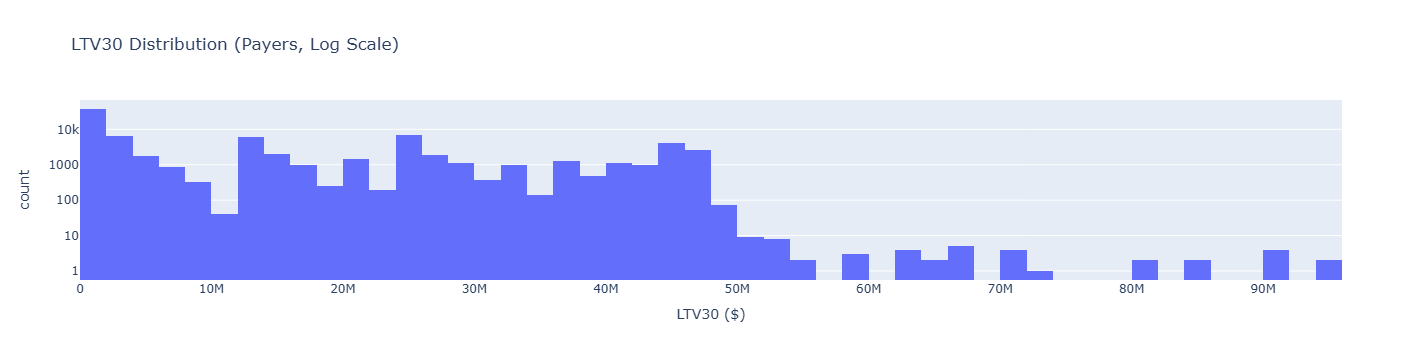

In [ ]:
# LTV30 Distribution with Currency Toggle
ltv_display = convert_currency(df[df['ltv30'] > 0]['ltv30'], CURRENCY)

fig = px.histogram(
    ltv_display, 
    nbins=50,
    title=f'LTV30 Distribution (Payers Only, Log Scale) - {CURRENCY}',
    log_y=True, 
    labels={'value': f'LTV30 ({currency_symbol})'}
)
fig.update_layout(showlegend=False, xaxis_title=f'LTV30 ({currency_symbol})')
fig.show()

In [ ]:
# Cumulative Revenue Decile Table
ltv_sorted_desc = df.sort_values('ltv30', ascending=False).reset_index(drop=True)
total_rev = ltv_sorted_desc['ltv30'].sum()
n_users = len(ltv_sorted_desc)

deciles = []
for i in range(10):
    start_idx = int(n_users * i / 10)
    end_idx = int(n_users * (i + 1) / 10)
    decile_users = ltv_sorted_desc.iloc[start_idx:end_idx]
    decile_rev = decile_users['ltv30'].sum()
    pct_rev = (decile_rev / total_rev * 100) if total_rev > 0 else 0
    
    deciles.append({
        'Decile': f'Top {i*10}-{(i+1)*10}%',
        'Users': len(decile_users),
        f'Revenue ({currency_symbol})': format_currency(decile_rev, CURRENCY),
        '% of Total Revenue': f'{pct_rev:.1f}%',
    })

# Add cumulative column
cumulative = 0
for d in deciles:
    pct = float(d['% of Total Revenue'].rstrip('%'))
    cumulative += pct
    d['Cumulative %'] = f'{cumulative:.1f}%'

decile_df = pd.DataFrame(deciles)
print("📊 Cumulative Revenue by Decile:")
print(decile_df.to_string(index=False))

✅ Report written: C:\Users\CPU12830-local\code\cfm_pltv\reports\decision_definition.md
Done!


In [ ]:
# Lorenz Curve (Revenue Inequality)
sorted_ltv = np.sort(df['ltv30'].values)
cum_users = np.arange(1, len(sorted_ltv) + 1) / len(sorted_ltv)
cum_revenue = np.cumsum(sorted_ltv) / sorted_ltv.sum() if sorted_ltv.sum() > 0 else np.zeros_like(sorted_ltv)

# Sample for plotting
sample_idx = np.linspace(0, len(cum_users) - 1, 1000, dtype=int)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=cum_users[sample_idx] * 100, 
    y=cum_revenue[sample_idx] * 100,
    name='Actual Distribution',
    line=dict(color='royalblue', width=2)
))
fig.add_trace(go.Scatter(
    x=[0, 100], y=[0, 100],
    name='Perfect Equality',
    line=dict(dash='dash', color='gray')
))
fig.update_layout(
    title=f'Lorenz Curve — Revenue Inequality (Gini = {gini:.3f})',
    xaxis_title='Cumulative % of Users (sorted by LTV)',
    yaxis_title='Cumulative % of Revenue',
    height=400
)
fig.show()

print(f"📈 Gini Coefficient: {gini:.3f}")
print("   (F2P games typically: 0.85-0.95, higher = more concentrated)")

In [ ]:
# Whale Economy Analysis - Tier Segmentation
df['ltv_quantile'] = pd.qcut(df['ltv30'], q=4, labels=['Non-Payer', 'Minnow', 'Dolphin', 'Whale'], duplicates='drop')

tier_stats = df.groupby('ltv_quantile', observed=True).agg(
    users=('vopenid', 'count'),
    total_revenue=('ltv30', 'sum'),
    avg_ltv=('ltv30', 'mean'),
    avg_rev_d7=('rev_d7', 'mean'),
    avg_games_d7=('games_d7', 'mean'),
    avg_active_days=('active_days_d7', 'mean'),
).reset_index()

tier_stats['pct_users'] = tier_stats['users'] / tier_stats['users'].sum() * 100
tier_stats['pct_revenue'] = tier_stats['total_revenue'] / tier_stats['total_revenue'].sum() * 100

print("🐋 Whale Economy - Tier Segmentation:")
print(f"\n{'Tier':<12} {'Users':<10} {'% Users':<10} {'% Revenue':<12} {'Avg LTV':<15}")
print("-" * 70)
for _, row in tier_stats.iterrows():
    print(f"{row['ltv_quantile']:<12} {row['users']:<10,} {row['pct_users']:<10.1f} {row['pct_revenue']:<12.1f} {format_currency(row['avg_ltv'], CURRENCY):<15}")

# Whale concentration
whale_rev_share = tier_stats[tier_stats['ltv_quantile'] == 'Whale']['pct_revenue'].values[0] if 'Whale' in tier_stats['ltv_quantile'].values else 0
print(f"\n💰 Whale tier captures {whale_rev_share:.1f}% of total revenue")

## Summary

This notebook provides decision-level analysis including:
- Key KPIs (ARPU, payer rate, revenue concentration)
- Revenue distribution and Gini coefficient
- Lorenz curve visualization
- Whale economy tier segmentation

**Note:** This is an exploratory notebook. It does NOT write to report MD files.